# Large scale learning with kernels

1. [Imports](#imports)
2. [Random Fourier Features](#rff)
3. [Nÿstrom](#nÿstrom)
3. [Experiments on synthetic data](#synthetic)
    1. [Performance with D](#synt_D)
    2. [Influence of the regularization](#synt_reg)
4. [Experiments on the CT Slices dataset](#CT)
    1. [Performance with D](#CT_D)
    2. [Influence of the regularization](#CT_reg)
5. [Experiments on the MillionSongs dataset](#MillionSongs)
    1. [Performance with D](#MillionSongs_D)
    2. [Influence of the regularization](#MillionSongs_reg)

## Imports <a name="imports"></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_squared_error
from time import time
import matplotlib.pyplot as plt

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd
import os

DATA = {
    "YearPredictionMSD.txt.zip": "1R3CXYssjftxi7HIXXgeWCAZh65ByEumt",
    "slice_localization_data.zip": "1ZJamggugQuj-sE1EFWfghhR3dEY2K9Ib",
}

for file_name, file_id in DATA.items():
    output_file = os.path.join('data', file_name)
    gdd.download_file_from_google_drive(file_id=file_id, dest_path=output_file)

## Random Fourier Features <a name="rff"></a>

In [3]:
class RFF(object):
    def __init__(self, D=100, kernel="gaussian", gamma="scale", method=0):
        self.D = D
        self.kernel = kernel
        self.gamma = gamma
        self.method = method

    def fit(self, X, y=None):
        d = X.shape[1]
        if self.kernel == "gaussian":
            mu = np.zeros(d)
            if self.gamma == "scale":
                sigma = (1/(d*X.var()))*np.identity(d)
            elif self.gamma == "auto":
                sigma = (1/d)*np.identity(d)
            elif type(self.gamma) == float:
                sigma = gamma*np.identity(d)
            else:
                raise TypeError("gamma must be either 'scale', 'auto', or a float.")
            self.w = np.random.multivariate_normal(mu, sigma, self.D)
            if self.method == 0:
                pass
            elif self.method == 1:
                self.b = np.random.uniform(0, 2*np.pi, self.D)
            else:
                raise TypeError("method must be either 0 or 1.")
        return self
                
    def transform(self, X):
        if self.kernel == "gaussian":
            if self.method == 0:
                return np.sqrt(1/self.D) * np.concatenate((np.cos(np.dot(X, self.w.T)), np.sin(np.dot(X, self.w.T))), axis=1)
            if self.method == 1:
                return np.sqrt(2/self.D) * np.cos(np.dot(X, self.w.T) + self.b)
            else:
                raise TypeError("method must be either 0 or 1.")

## Nyström <a name="nÿstrom"></a>

Create Nyström class

## Experiments on synthetic data <a name="synthetic"></a>

### Performance with D <a name="synt_D"></a>

### Influence of the regularization  <a name="synt_reg"></a>

## Experiments on the CT Slices dataset <a name="CT"></a>

In [4]:
data = pd.read_csv('data/slice_localization_data.zip')

In [5]:
data.shape

(53500, 386)

In [6]:
features = data.drop('reference', axis=1)

In [7]:
y = data.loc[:,'reference']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=24)
X_train = X_train.values
X_test = X_test.values

In [9]:
lin = Pipeline([('Scaler',StandardScaler()),
                ('LinearSVR', LinearSVR()),])

t0 = time()
lin.fit(X_train, y_train)
time_lin = time() - t0

y_pred_train_lin = lin.predict(X_train)                      
score_train_lin = mean_squared_error(y_train, y_pred_train_lin)

y_pred_lin = lin.predict(X_test)                      
score_lin = mean_squared_error(y_test, y_pred_lin)

/Users/margauxzaffran/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [10]:
gauss = Pipeline([('Scaler',StandardScaler()),
                  ('SVR', SVR(kernel='rbf')),])

t0 = time()
gauss.fit(X_train, y_train)
time_gauss = time() - t0

y_pred_train_gauss = gauss.predict(X_train)                      
score_train_gauss = mean_squared_error(y_train, y_pred_train_gauss)

y_pred_gauss = gauss.predict(X_test)                      
score_gauss = mean_squared_error(y_test, y_pred_gauss)

### Performance with D <a name="CT_D"></a>

In [11]:
nD = 10
list_D = np.linspace(300,3500,nD,dtype=int)
M = 10
scores_rff = np.empty((nD,M))
scores_train_rff = np.empty((nD,M))
times_rff = np.empty((nD,M))

for i,D in enumerate(list_D):
    for j in range(M):
        rff = Pipeline([('Scaler',StandardScaler()),
                        ('RFF',RFF(D = D)),
                        ('LinearSVR', LinearSVR()),])
        
        t0 = time()
        rff.fit(X_train, y_train)
        times_rff[i,j] = time() - t0
        
        y_pred_train_rff = rff.predict(X_train)                      
        scores_train_rff[i,j] = mean_squared_error(y_train, y_pred_train_rff)
        
        y_pred_rff = rff.predict(X_test)                      
        scores_rff[i,j] = mean_squared_error(y_test, y_pred_rff)

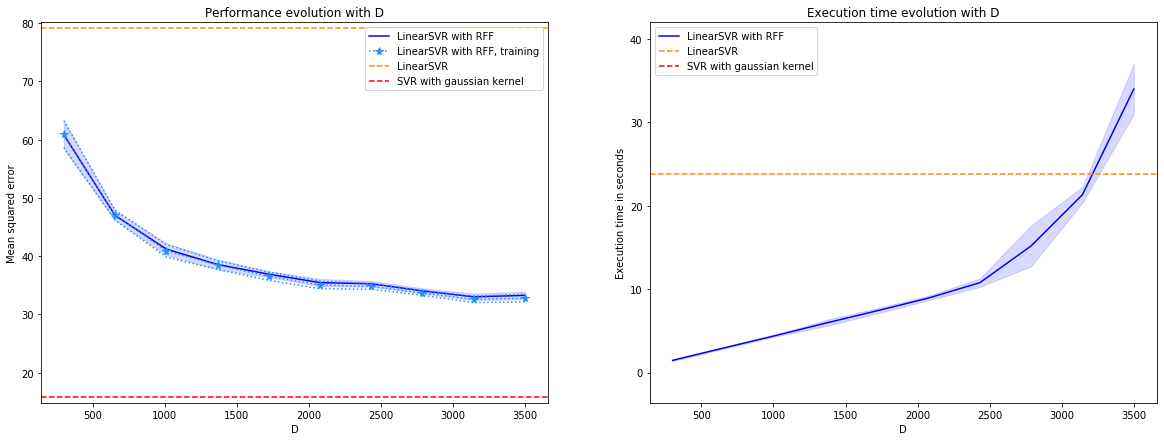

In [104]:
fig = plt.figure(figsize=(20,7))

# Plot of the performance

ax1 = plt.subplot(1,2,1)

y_max = max(max(np.mean(scores_rff, axis=1) + np.std(scores_rff, axis=1)),
            max(np.mean(scores_train_rff, axis=1) + np.std(scores_train_rff, axis=1)),
            score_lin, score_gauss)+1
y_min = min(min(np.mean(scores_rff, axis=1) - np.std(scores_rff, axis=1)),
            min(np.mean(scores_train_rff, axis=1) - np.std(scores_train_rff, axis=1)),
            score_lin, score_gauss)-1

ax1.set_ylim(y_min, y_max)

ax1.plot(list_D, np.mean(scores_rff, axis=1), '-', color='blue', label='LinearSVR with RFF')
ax1.fill_between(list_D, np.mean(scores_rff, axis=1) - np.std(scores_rff, axis=1),
                 np.mean(scores_rff, axis=1) + np.std(scores_rff, axis=1), 
                 color='blue', alpha=0.15)
ax1.plot(list_D, np.mean(scores_train_rff, axis=1), '*', markersize=8, color='dodgerblue',
         label='LinearSVR with RFF, training')
ax1.plot(list_D, np.mean(scores_train_rff, axis=1) - np.std(scores_train_rff, axis=1), ':',color='dodgerblue')
ax1.plot(list_D, np.mean(scores_train_rff, axis=1) + np.std(scores_train_rff, axis=1), ':',color='dodgerblue')

ax1.axhline(y=score_lin, color='darkorange', linestyle='--', label='LinearSVR')
ax1.axhline(y=score_gauss, color='r', linestyle='--', label='SVR with gaussian kernel')

ax1.set_title("Performance evolution with D")
ax1.set_xlabel("D")
ax1.set_ylabel("Mean squared error")

handles, labels = ax1.get_legend_handles_labels()
handles[1].set_linestyle(':')
ax1.legend(loc='upper right', handles=handles, labels=labels)

# Plot of the execution time

ax2 = plt.subplot(1,2,2)

y_max = max(max(np.mean(times_rff, axis=1) + np.std(times_rff, axis=1)),time_lin)+5
y_min = min(min(np.mean(times_rff, axis=1) - np.std(times_rff, axis=1)),time_lin)-5

ax2.set_ylim(y_min, y_max)

ax2.plot(list_D, np.mean(times_rff, axis=1), '-', color='blue', label='LinearSVR with RFF')
ax2.fill_between(list_D, np.mean(times_rff, axis=1) - np.std(times_rff, axis=1),
                 np.mean(times_rff, axis=1) + np.std(times_rff, axis=1), 
                 color='blue', alpha=0.15)

ax2.axhline(y=time_lin, color='darkorange', linestyle='--', label='LinearSVR')
ax2.axhline(y=time_gauss, color='r', linestyle='--', label='SVR with gaussian kernel')

ax2.set_title("Execution time evolution with D")
ax2.set_xlabel("D")
ax2.set_ylabel("Execution time in seconds")

ax2.legend(loc='upper left')

plt.savefig("D_influence_CT")
plt.show()

In [13]:
print("SVR with gaussian kernel execution time:", time_gauss)

SVR with gaussian kernel execution time: 1274.2267017364502


### Influence of the regularization  <a name="CT_reg"></a>

In [14]:
nC = 8
list_C = np.linspace(0.01,2,nC)
M = 10

In [15]:
scores_rff_l1 = np.empty((nC,M))
scores_train_rff_l1 = np.empty((nC,M))
times_rff_l1 = np.empty((nC,M))

for i,C in enumerate(list_C):
    for j in range(M):
        rff = Pipeline([('Scaler',StandardScaler()),
                        ('RFF',RFF(D = 2000)),
                        ('LinearSVR', LinearSVR(C = C)),])
        
        t0 = time()
        rff.fit(X_train, y_train)
        times_rff_l1[i,j] = time() - t0

        y_pred_train_rff = rff.predict(X_train)                      
        scores_train_rff_l1[i,j] = mean_squared_error(y_train, y_pred_train_rff)
        
        y_pred_rff = rff.predict(X_test)                      
        scores_rff_l1[i,j] = mean_squared_error(y_test, y_pred_rff)

In [16]:
scores_rff_l2 = np.empty((nC,M))
scores_train_rff_l2 = np.empty((nC,M))
times_rff_l2 = np.empty((nC,M))

for i,C in enumerate(list_C):
    for j in range(M):
        rff = Pipeline([('Scaler',StandardScaler()),
                        ('RFF',RFF(D = 2000)),
                        ('LinearSVR', LinearSVR(C = C, loss='squared_epsilon_insensitive')),])
        
        t0 = time()
        rff.fit(X_train, y_train)
        times_rff_l2[i,j] = time() - t0

        y_pred_train_rff = rff.predict(X_train)                      
        scores_train_rff_l2[i,j] = mean_squared_error(y_train, y_pred_train_rff)
        
        y_pred_rff = rff.predict(X_test)                      
        scores_rff_l2[i,j] = mean_squared_error(y_test, y_pred_rff)

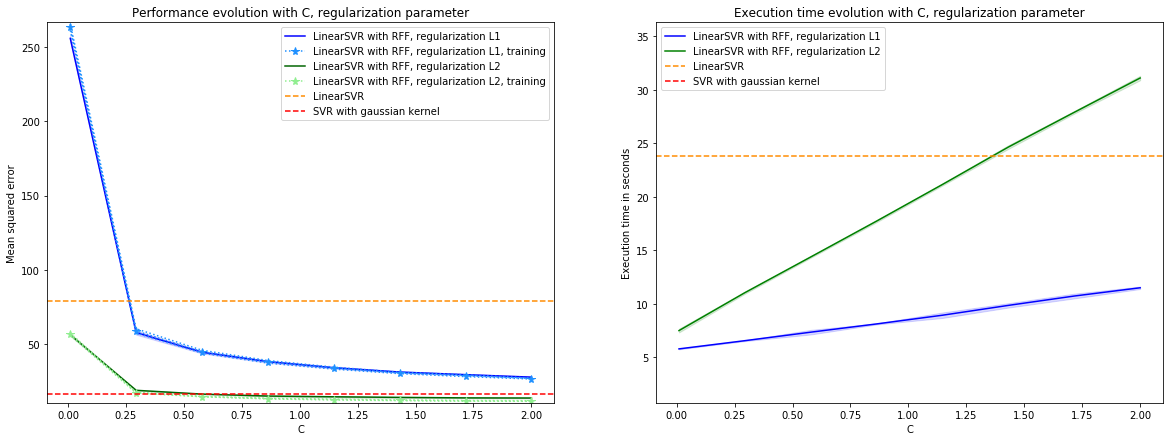

In [103]:
fig = plt.figure(figsize=(20,7))

# Plot of the performance

ax1 = plt.subplot(1,2,1)

y_max = max(max(np.mean(scores_rff_l1, axis=1) + np.std(scores_rff_l1, axis=1)),
            max(np.mean(scores_train_rff_l1, axis=1) + np.std(scores_train_rff_l1, axis=1)),
            max(np.mean(scores_rff_l2, axis=1) + np.std(scores_rff_l2, axis=1)),
            max(np.mean(scores_train_rff_l2, axis=1) + np.std(scores_train_rff_l2, axis=1)),
            score_lin, score_gauss)+1
y_min = min(min(np.mean(scores_rff_l1, axis=1) - np.std(scores_rff_l1, axis=1)),
            min(np.mean(scores_train_rff_l1, axis=1) - np.std(scores_train_rff_l1, axis=1)),
            min(np.mean(scores_rff_l2, axis=1) - np.std(scores_rff_l2, axis=1)),
            min(np.mean(scores_train_rff_l2, axis=1) - np.std(scores_train_rff_l2, axis=1)),
            score_lin, score_gauss)-1

ax1.set_ylim(y_min, y_max)

ax1.plot(list_C, np.mean(scores_rff_l1, axis=1), '-', color='blue', label='LinearSVR with RFF, regularization L1')
ax1.fill_between(list_C, np.mean(scores_rff_l1, axis=1) - np.std(scores_rff_l1, axis=1),
                 np.mean(scores_rff_l1, axis=1) + np.std(scores_rff_l1, axis=1), 
                 color='blue', alpha=0.15)

ax1.plot(list_C, np.mean(scores_train_rff_l1, axis=1), '*', markersize=8, color='dodgerblue',
         label='LinearSVR with RFF, regularization L1, training')
ax1.plot(list_C, np.mean(scores_train_rff_l1, axis=1) - np.std(scores_train_rff_l1, axis=1), ':',color='dodgerblue')
ax1.plot(list_C, np.mean(scores_train_rff_l1, axis=1) + np.std(scores_train_rff_l1, axis=1), ':',color='dodgerblue')

ax1.plot(list_C, np.mean(scores_rff_l2, axis=1), '-', color='darkgreen', label='LinearSVR with RFF, regularization L2')
ax1.fill_between(list_C, np.mean(scores_rff_l2, axis=1) - np.std(scores_rff_l2, axis=1),
                 np.mean(scores_rff_l2, axis=1) + np.std(scores_rff_l2, axis=1), 
                 color='darkgreen', alpha=0.15)

ax1.plot(list_C, np.mean(scores_train_rff_l2, axis=1), '*', markersize=8, color='lightgreen',
         label='LinearSVR with RFF, regularization L2, training')
ax1.plot(list_C, np.mean(scores_train_rff_l2, axis=1) - np.std(scores_train_rff_l2, axis=1), ':',color='lightgreen')
ax1.plot(list_C, np.mean(scores_train_rff_l2, axis=1) + np.std(scores_train_rff_l2, axis=1), ':',color='lightgreen')

ax1.axhline(y=score_lin, color='darkorange', linestyle='--', label='LinearSVR')
ax1.axhline(y=score_gauss, color='r', linestyle='--', label='SVR with gaussian kernel')

ax1.set_title("Performance evolution with C, regularization parameter")
ax1.set_xlabel("C")
ax1.set_ylabel("Mean squared error")

handles, labels = ax1.get_legend_handles_labels()
handles[1].set_linestyle(':')
handles[3].set_linestyle(':')
ax1.legend(loc='upper right', handles=handles, labels=labels)

# Plot of the execution time

ax2 = plt.subplot(1,2,2)

y_max = max(max(np.mean(times_rff_l1, axis=1) + np.std(times_rff_l1, axis=1)),
            max(np.mean(times_rff_l2, axis=1) + np.std(times_rff_l2, axis=1)),
            time_lin)+5
y_min = min(min(np.mean(times_rff_l1, axis=1) - np.std(times_rff_l1, axis=1)),
            min(np.mean(times_rff_l2, axis=1) - np.std(times_rff_l2, axis=1)),
            time_lin)-5

ax2.set_ylim(y_min, y_max)

ax2.plot(list_C, np.mean(times_rff_l1, axis=1), '-', color='blue', label='LinearSVR with RFF, regularization L1')
ax2.fill_between(list_C, np.mean(times_rff_l1, axis=1) - np.std(times_rff_l1, axis=1),
                 np.mean(times_rff_l1, axis=1) + np.std(times_rff_l1, axis=1), 
                 color='blue', alpha=0.15)

ax2.plot(list_C, np.mean(times_rff_l2, axis=1), '-', color='green', label='LinearSVR with RFF, regularization L2')
ax2.fill_between(list_C, np.mean(times_rff_l2, axis=1) - np.std(times_rff_l2, axis=1),
                 np.mean(times_rff_l2, axis=1) + np.std(times_rff_l2, axis=1), 
                 color='green', alpha=0.15)

ax2.axhline(y=time_lin, color='darkorange', linestyle='--', label='LinearSVR')
ax2.axhline(y=time_gauss, color='r', linestyle='--', label='SVR with gaussian kernel')

ax2.set_title("Execution time evolution with C, regularization parameter")
ax2.set_xlabel("C")
ax2.set_ylabel("Execution time in seconds")

ax2.legend(loc='upper left')

plt.savefig("Regularization_influence_CT.png")
plt.show()

In [18]:
print("SVR with gaussian kernel execution time:", time_gauss)

SVR with gaussian kernel execution time: 1274.2267017364502


In [105]:
np.savetxt('CT_results/scores_rff.csv', scores_rff, delimiter=',')
np.savetxt('CT_results/scores_train_rff.csv', scores_train_rff, delimiter=',')
np.savetxt('CT_results/times_rff.csv', times_rff, delimiter=',')
np.savetxt('CT_results/list_D.csv', list_D, delimiter=',')
np.savetxt('CT_results/scores_rff_l1.csv', scores_rff_l1, delimiter=',')
np.savetxt('CT_results/scores_train_rff_l1.csv', scores_train_rff_l1, delimiter=',')
np.savetxt('CT_results/times_rff_l1.csv', times_rff_l1, delimiter=',')
np.savetxt('CT_results/scores_rff_l2.csv', scores_rff_l2, delimiter=',')
np.savetxt('CT_results/scores_train_rff_l2.csv', scores_train_rff_l2, delimiter=',')
np.savetxt('CT_results/times_rff_l2.csv', times_rff_l2, delimiter=',')
np.savetxt('CT_results/list_C.csv', list_C, delimiter=',')
np.savetxt('CT_results/score_lin.csv', np.asarray([score_lin]), delimiter=',')
np.savetxt('CT_results/score_train_lin.csv', np.asarray([score_train_lin]), delimiter=',')
np.savetxt('CT_results/time_lin.csv', np.asarray([time_lin]), delimiter=',')
np.savetxt('CT_results/score_gauss.csv', np.asarray([score_gauss]), delimiter=',')
np.savetxt('CT_results/score_train_gauss.csv', np.asarray([score_train_gauss]), delimiter=',')
np.savetxt('CT_results/time_gauss.csv', np.asarray([time_gauss]), delimiter=',')

## Experiments on the MillionSongs dataset <a name="MillionSongs"></a>

### Performance with D <a name="MillionSongs_D"></a>

### Influence of the regularization  <a name="MillionSongs_reg"></a>